In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

# データの準備

In [5]:
df = pd.read_csv('ebina_kion.csv')
df.head()

,Month,kion
0,1997/1,4.8
1,1997/2,5.8
2,1997/3,9.7
3,1997/4,14.3
4,1997/5,18.5


In [3]:
df.tail()

,Month,kion
260,2018/9,22.8
261,2018/10,18.9
262,2018/11,13.7
263,2018/12,8.0
264,2019/1,4.9


In [6]:
kion = pd.Series(df['kion'], dtype='float')
kion.index = pd.to_datetime(df['Month'])

print(kion.index.dtype)
print(len(kion))
kion.head()

datetime64[ns]
265


Month
1997-01-01     4.8
1997-02-01     5.8
1997-03-01     9.7
1997-04-01    14.3
1997-05-01    18.5
Name: kion, dtype: float64

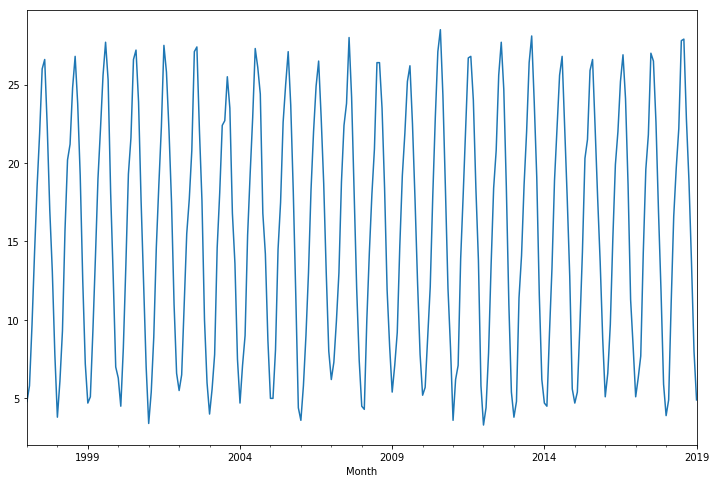

In [7]:
plt.figure(figsize=(12,8))
kion.plot()

# データの分析

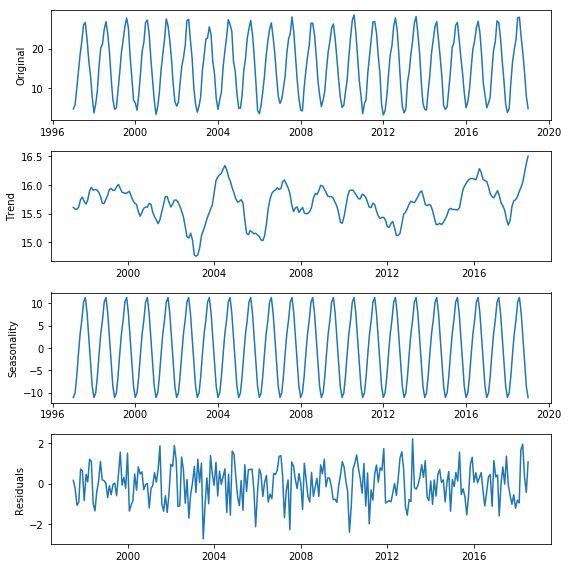

In [8]:
#分解
res = sm.tsa.seasonal_decompose(kion)

original = kion # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout()

In [9]:
#月別平均
kion.groupby(kion.index.month).mean()

Month
1      4.617391
2      5.654545
3      9.181818
4     14.290909
5     18.809091
6     21.954545
7     25.918182
8     26.959091
9     23.418182
10    18.000000
11    12.359091
12     7.086364
Name: kion, dtype: float64

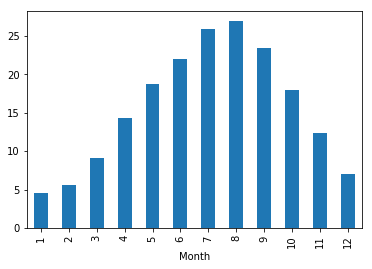

In [10]:
kion_month_mean = kion.groupby(kion.index.month).mean()
kion_month_mean.plot(kind='bar')

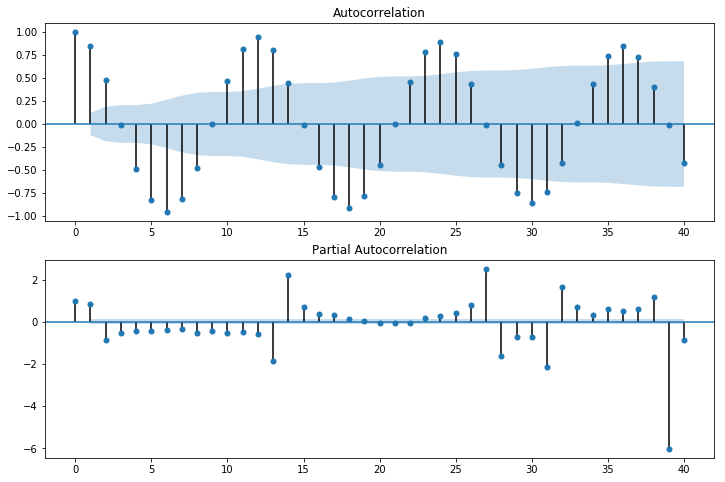

In [11]:
#コレログラム
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(kion.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(kion, lags=40, ax=ax2)

# モデル推定

In [12]:
# 単位根検定
adf_result = sm.tsa.stattools.adfuller(kion)
adf_result
# 棄却→単位根でない

(-4.203809717218636,
 0.0006491841431129272,
 16,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 778.7456473301374)

In [13]:
# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(kion, max_ar=3, max_ma=3, ic='aic', trend='nc')
res_selection

{'aic':              0            1            2            3
 0          NaN  1936.610343  1705.371961  1538.156714
 1  1513.378109  1370.449286  1304.571476  1398.657873
 2  1285.036418          NaN  1261.706312          NaN
 3  1276.855976  1287.670332          NaN  1066.180712,
 'aic_min_order': (3, 3)}

In [14]:
# SARIMAモデル作成その１
sarimax = sm.tsa.SARIMAX(kion, 
                        order=(3, 0, 3),
                        seasonal_order=(3, 0, 3, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

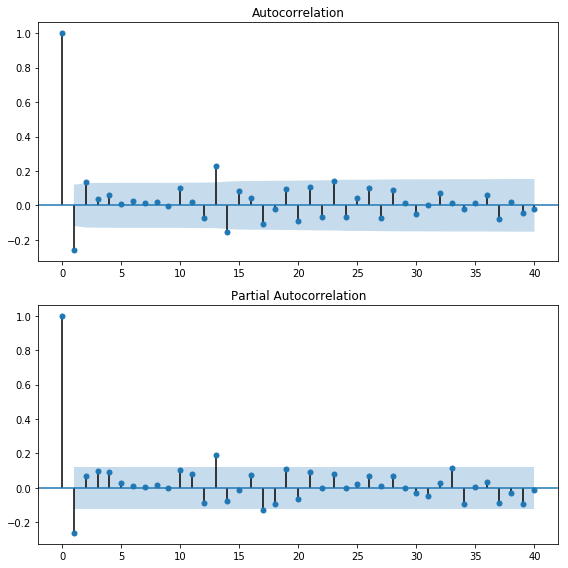

In [15]:
sarimax_resid = sarimax.resid # モデルの残差成分

# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

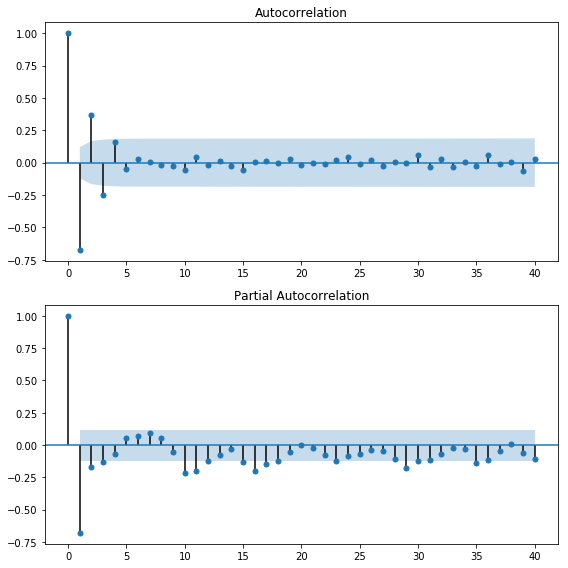

In [16]:
# SARIMAモデル（試しに）季節調整なし
sarimax_noseasonal = sm.tsa.SARIMAX(kion, 
                        order=(3, 0, 3),
                        seasonal_order=(3, 0, 3, 0),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_noseasonal_resid = sarimax_noseasonal.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_noseasonal_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_noseasonal_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [17]:
print(sarimax.aic) # 季節調整あり
print(sarimax_noseasonal.aic) # 季節調整なし

669.705000600894
967.3352795474677


In [18]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               kion   No. Observations:                  265
Model:             SARIMAX(3, 0, 3)x(3, 0, 3, 12)   Log Likelihood                -321.853
Date:                            Sun, 30 Jun 2019   AIC                            669.705
Time:                                    12:01:05   BIC                            714.114
Sample:                                01-01-1997   HQIC                           687.629
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2288      0.211     10.539      0.000       1.814       2.643
ar.L2         -1.7442      0.389     -4.488      0.000      -2.506      -0.983
ar.L3          0.4446      0.206      2.162      0.031       0.042       0.848
ma.L1         -1.9923      0.230     -8.661      0.000      -2.443      -1.541
ma.L2          1.2765      0.420      3.039      0.002       0.453       2.100
ma.L3         -0.1744      0.223     -0.781      0.435      -0.612       0.263
ar.S.L12       0.2383      0.267      0.894      0.371      -0.284       0.761
ar.S.L24       0.3373      0.206      1.634      0.102      -0.067       0.742
ar.S.L36       0.4261      0.201      2.125      0.034       0.033       0.819
ma.S.L12      -0.2693      0.461     -0.584      0.559      -1.174       0.635
ma.S.L24      -0.4238      0.327     -1.296      0.195      -1.065       0.217
ma.S.L36      -0.3576      0.244     -1.464      0.143      -0.836       0.121
sigma2         0.8525      0.312      2.730      0.006       0.240       1.465
===================================================================================
Ljung-Box (Q):                       53.27   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.08   Prob(JB):                         0.61
Heteroskedasticity (H):               0.78   Skew:                            -0.16
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

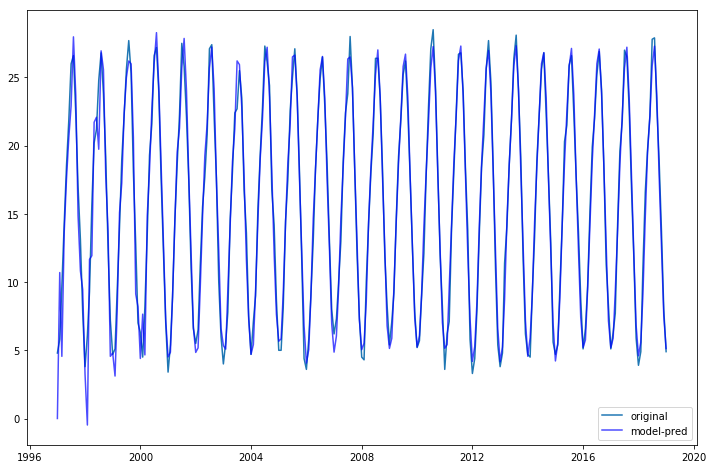

In [19]:
sarimax_pred = sarimax.predict('1997-01', '2019-1') 

plt.figure(figsize=(12, 8))

#元データ
plt.plot(kion, label="original")
#モデル
plt.plot(sarimax_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

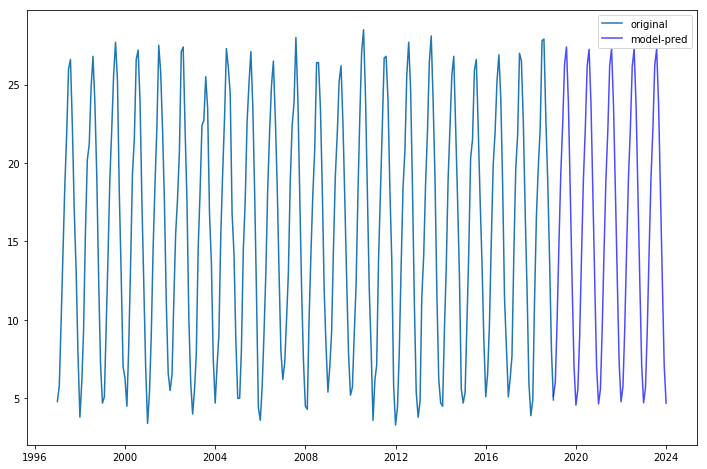

In [20]:
#先5年まで予測
sarimax_pred = sarimax.predict('2019-01', '2024-1') 

plt.figure(figsize=(12, 8))

plt.plot(kion, label="original")
plt.plot(sarimax_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

# train & predict

In [21]:
kion_train = kion['1997-01':'2015-12'] # モデル作成用データ 18年分
print(kion_train.head())
print(kion_train.tail())

Month
1997-01-01     4.8
1997-02-01     5.8
1997-03-01     9.7
1997-04-01    14.3
1997-05-01    18.5
Name: kion, dtype: float64
Month
2015-08-01    26.6
2015-09-01    22.3
2015-10-01    17.8
2015-11-01    13.7
2015-12-01     8.8
Name: kion, dtype: float64


In [22]:
kion_test = kion['2015-01':'2019-1'] # テスト用データ4年分
print(kion_test.head())
print(kion_test.tail())

Month
2015-01-01     4.7
2015-02-01     5.4
2015-03-01     9.6
2015-04-01    14.3
2015-05-01    20.3
Name: kion, dtype: float64
Month
2018-09-01    22.8
2018-10-01    18.9
2018-11-01    13.7
2018-12-01     8.0
2019-01-01     4.9
Name: kion, dtype: float64


In [23]:
# SRIMAモデル（テストデータを4年分除いてモデル作成）
sarimax_train = sm.tsa.SARIMAX(kion_train, 
                        order=(3, 0, 3),
                        seasonal_order=(3, 0, 3, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

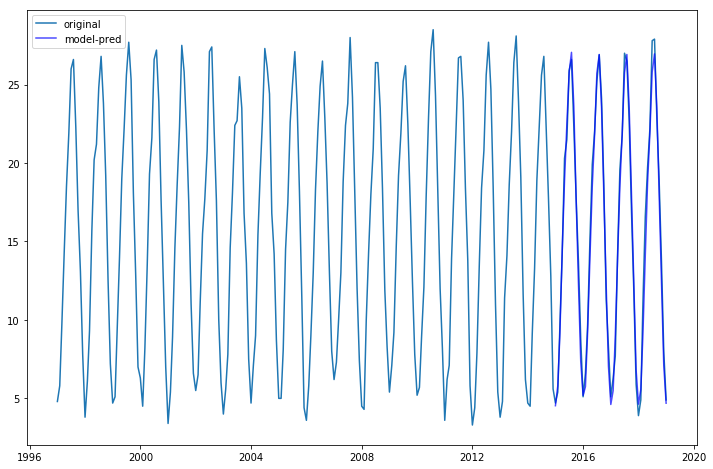

In [24]:
sarimax_train_pred = sarimax_train.predict('2015-01', '2019-1') # テストデータ4年分予測

plt.figure(figsize=(12, 8))

plt.plot(kion, label="original")
plt.plot(sarimax_train_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

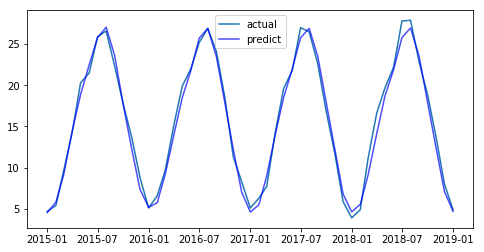

In [25]:
plt.figure(figsize=(8, 4))

plt.plot(kion_test, label="actual") # 正解
plt.plot(sarimax_train_pred, c="b", label="predict", alpha=0.7) # 予測
plt.legend(loc='best')

In [26]:
predict_dy = sarimax_train.get_prediction(start ='2015-12', end='2019-1')
type(predict_dy)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [27]:
predict_dy_ci = predict_dy.conf_int(alpha=0.05) #95%信頼区間
type(predict_dy_ci)

pandas.core.frame.DataFrame

In [28]:
predict_dy_ci # lower, upper取得

,lower kion,upper kion
2015-12-01,5.473804,9.236171
2016-01-01,3.304751,7.066940
2016-02-01,3.817701,7.669380
2016-03-01,7.302546,11.150547
2016-04-01,12.079170,15.933711
2016-05-01,16.546535,20.416703
2016-06-01,19.859518,23.748436
2016-07-01,23.772810,27.679511
2016-08-01,24.959153,28.880814
2016-09-01,21.515479,25.448830


In [29]:
predict_dy.predicted_mean # mean取得

2015-12-01     7.354987
2016-01-01     5.185846
2016-02-01     5.743540
2016-03-01     9.226546
2016-04-01    14.006441
2016-05-01    18.481619
2016-06-01    21.803977
2016-07-01    25.726161
2016-08-01    26.919984
2016-09-01    23.482155
2016-10-01    17.966814
2016-11-01    12.201820
2016-12-01     7.034185
2017-01-01     4.610108
2017-02-01     5.496706
2017-03-01     8.978027
2017-04-01    14.018374
2017-05-01    18.511800
2017-06-01    21.971237
2017-07-01    25.768374
2017-08-01    26.921171
2017-09-01    23.498536
2017-10-01    17.984875
2017-11-01    12.318663
2017-12-01     6.818819
2018-01-01     4.630545
2018-02-01     5.555151
2018-03-01     9.097063
2018-04-01    14.101443
2018-05-01    18.725652
2018-06-01    21.913110
2018-07-01    25.803083
2018-08-01    26.958322
2018-09-01    23.484623
2018-10-01    17.996533
2018-11-01    12.389073
2018-12-01     7.107080
2019-01-01     4.691774
Freq: MS, dtype: float64

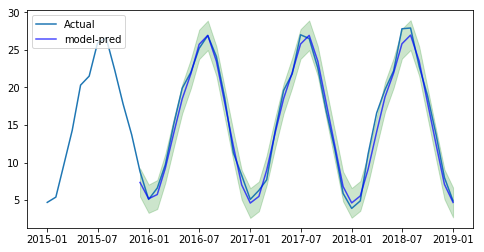

In [30]:
plt.figure(figsize=(8, 4))

plt.plot(kion_test, label="Actual")
plt.plot(predict_dy.predicted_mean, c="b", label="model-pred", alpha=0.7)

plt.fill_between(predict_dy_ci.index, predict_dy_ci.iloc[:, 0], predict_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.legend(loc='upper left')

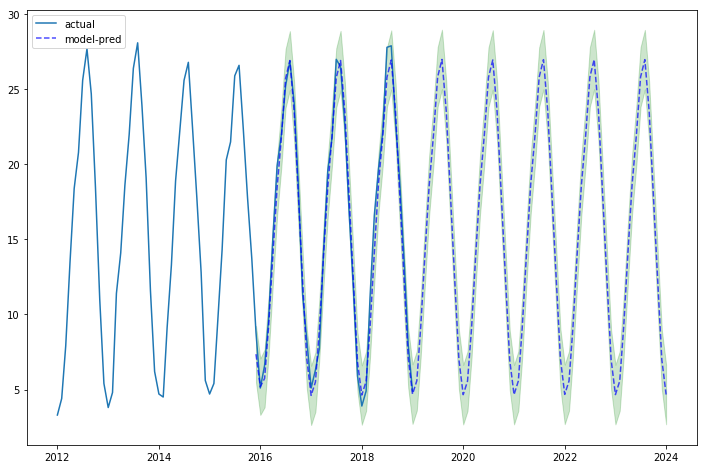

In [31]:
predict2_dy = sarimax_train.get_prediction(start ='2015-12', end='2024-1') # 5年分の未来予測

predict2_dy_ci = predict2_dy.conf_int()

plt.figure(figsize=(12, 8))
plt.plot(kion['2012-01':], label="actual")
plt.plot(predict2_dy.predicted_mean, c="b", linestyle='--', label="model-pred", alpha=0.7)

plt.fill_between(predict2_dy_ci.index, predict2_dy_ci.iloc[:, 0], predict2_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.legend(loc='upper left')